Import dataset images of forest and foliage 

In [1]:
import matplotlib.pyplot as ply
import cv2
from sklearn.datasets import load_files
from skimage.io import imread_collection 
from keras.utils import np_utils
import numpy as np
import pandas as pd 
from glob import glob
import os
import math

Using TensorFlow backend.


In [2]:
from sklearn.model_selection import train_test_split

path = "Datasets/train/"
# Function to load train, test and validation datasets

def load_training(path):
    
    # Load in training labels as a Pandas dataframe
    train_targets_data = pd.read_csv('Datasets/train_labels.csv',index_col = False)
    
    # Convert Dataframe into Numpy array
    train_targets = np.array(train_targets_data['invasive'].ix[:,])
    
    # Training image file paths stored as numpy array 'forest_files'
    train_files = np.array(glob("Datasets/train/*"))
    
    # Glob is unordered, sort in increasing numeric file name
    train_files = sorted(train_files, key=lambda name: int(name[15:-4]))
    
    # Insert filepath as name for training set
    train_targets_data['name'] = train_files
    
    return train_files, train_targets_data, train_targets
    
train_files, train_targets_data, train_targets = load_training(path)

In [3]:
train_targets_data.head()

,name,invasive
0,Datasets/train/1.jpg,0
1,Datasets/train/2.jpg,0
2,Datasets/train/3.jpg,1
3,Datasets/train/4.jpg,0
4,Datasets/train/5.jpg,1


In [3]:
from sklearn.model_selection import train_test_split

# Need to check that both training and valid files match the target labels.

train_files, valid_files, train_targets, valid_targets = train_test_split(train_files, train_targets, test_size = 0.2, random_state = 42)

In [4]:
path = "Datasets/test"

def load_testing(path):
    
    # Load in testing labels as a Pandas dataframe
    test_targets = pd.read_csv('Datasets/sample_submission.csv')
    
    # Forest testing image file paths stored as numpy array 'testing_images'
    test_files = np.array(glob('Datasets/test/*'))
    
    # Glob is unordered, sort in increasing numeric file name
    test_files = sorted(test_files, key = lambda name: int(name[14:-4]))
    
    return test_files, test_targets

test_files, test_targets = load_testing(path)

In [6]:
test_targets.head()

,name,invasive
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


### File Statistics

In [5]:
print('There are %s total forest images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training forest images.' % len(train_files))
print('There are %d validation forest images.' % len(valid_files))
print('There are %d test forest images.'% len(test_files))

There are 3826 total forest images.

There are 1836 training forest images.
There are 459 validation forest images.
There are 1531 test forest images.


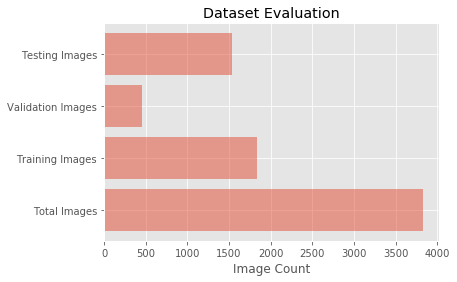

In [80]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')


total_forest = len(np.hstack([train_files, valid_files, test_files]))
total_train = len(train_files)
total_valid = len(valid_files)
total_test = len(test_files)

from matplotlib import pyplot as plt
import numpy as np
plt.style.use('ggplot')

objects = ['Total Images','Training Images','Validation Images','Testing Images']
y_pos = np.arange(len(objects))
count = [total_forest, total_train, total_valid, total_test]


plt.barh(y_pos, count, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Image Count')
plt.title('Dataset Evaluation')

plt.show()

### Pre-process the Data - Conversion into 4D Tensor

In [6]:
# Function to pre-proces the data into 4D array

from keras.preprocessing import image
from tqdm import tqdm

image_size = (400,400)

def path_tensor(img_path):
    
    # Takes RGB image and loads as PIL.Image.Image type
    img = image.load_img(img_path, target_size = image_size)
    
    # Convert the PIL.Image.Image type to a 3D tensor with the shape (224, 224, 3)
    x = image.img_to_array(img)
    
    # 3D tensor conversion to 4D tensor, shape (1, 224, 224, 3). Returns 4D tensor
    return np.expand_dims(x, axis = 0)

def paths_tensor(img_paths):
    list_tensors = [path_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_tensors)   
    

### Pre-process the Data - RGB to BGR, Mean Pixel 

In [ ]:
# Under consideration

### Run Data Pre-processing

In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Pre-Process the data for Keras
train_tensors = paths_tensor(train_files).astype('float32')/255
valid_tensors = paths_tensor(valid_files).astype('float32')/255
test_tensors = paths_tensor (test_files).astype('float32')/255

100%|██████████| 1531/1531 [03:54<00:00,  7.15it/s]


### Check Shape of Inputs

In [8]:
print("The shape of the training tensor is:",train_tensors.shape)
print("The shape of the training targets is:",train_targets.shape)
print("The shape of the validation tensor is:",valid_tensors.shape)
print("The shape of the validation targets is:",valid_targets.shape)
print("The shape of the testing tensor is:",test_tensors.shape)
print("The shape of the testing targets is:",test_targets.shape)

The shape of the training tensor is: (1836, 400, 400, 3)
The shape of the training targets is: (1836,)
The shape of the validation tensor is: (459, 400, 400, 3)
The shape of the validation targets is: (459,)
The shape of the testing tensor is: (1531, 400, 400, 3)
The shape of the testing targets is: (1531, 2)


## Obtain Bottleneck Features

In [9]:
from keras import applications
from keras.preprocessing import image 

img_width, img_height, img_channels = 400, 400, 3

### Obtain Bottleneck Features - VGG16

In [10]:
# Load in VGG16 bottleneck features

VGG16_bottleneck_features = applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, img_channels))

### Obtain Bottleneck Features - VGG19

In [ ]:
# Load in VGG19 bottleneck features

VGG19_bottleneck_features = applications.VGG19(include_top=False, weights='imagenet', input_shape=(img_width, img_height, img_channels))

### Obtain Bottleneck Features - Xception

In [ ]:
# Load in Xception bottleneck features

Xception_bottleneck_features = applications.Xception(include_top=False, weights='imagenet', input_shape=(img_width, img_height, img_channels))

### Obtain Bottleneck Features - Inception V3

In [15]:
# Load in Inception V3 bottleneck features

Inception_bottleneck_features = applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(img_width, img_height, img_channels))

### Obtain Bottleneck Features - ResNet50

In [13]:
# Load in ResNet50 bottleneck features

ResNet50_bottleneck_features = applications.ResNet50(include_top=False, weights='imagenet', input_shape=(img_width, img_height, img_channels))

## Model Architecture

In [11]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers

### Model Architecture VGG16

In [12]:

VGG16_model = Sequential()
VGG16_model.add(Flatten(input_shape = VGG16_bottleneck_features.output_shape[1:]))
VGG16_model.add(Dense(256, activation = 'relu'))
VGG16_model.add(Dropout(0.5))
VGG16_model.add(Dense(1, activation = 'sigmoid'))

model_VGG16 = Model(inputs = VGG16_bottleneck_features.input, outputs = VGG16_model(VGG16_bottleneck_features.output))

### Model Architecture VGG19

In [ ]:

VGG19_model = Sequential()
VGG19_model.add(Flatten(input_shape = VGG19_bottleneck_features.output_shape[1:]))
VGG19_model.add(Dense(256, activation = 'relu'))
VGG19_model.add(Dropout(0.5))
VGG19_model.add(Dense(1, activation = 'sigmoid'))

model_VGG19 = Model(inputs = VGG19_bottleneck_features.input, outputs = VGG19_model(VGG19_bottleneck_features.output))

### Model Architecture Xception

In [ ]:

Xception_model = Sequential()
Xception_model.add(Flatten(input_shape = Xception_bottleneck_features.output_shape[1:]))
Xception_model.add(Dense(256, activation = 'relu'))
Xception_model.add(Dropout(0.5))
Xception_model.add(Dense(1, activation = 'sigmoid'))

model_Xception = Model(inputs = Xception_bottleneck_features.input, outputs = Xception_model(Xception_bottleneck_features.output))

### Model Architecture Inception V3

In [17]:

Inception_model = Sequential()
Inception_model.add(Flatten(input_shape = Inception_bottleneck_features.output_shape[1:]))
Inception_model.add(Dense(256, activation = 'relu'))
Inception_model.add(Dropout(0.5))
Inception_model.add(Dense(1, activation = 'sigmoid'))

model_Inception = Model(inputs = Inception_bottleneck_features.input, outputs = Inception_model(Inception_bottleneck_features.output))

### Model Architecture ResNet50

In [15]:

ResNet50_model = Sequential()
ResNet50_model.add(Flatten(input_shape = ResNet50_bottleneck_features.output_shape[1:]))
ResNet50_model.add(Dense(256, activation = 'relu'))
ResNet50_model.add(Dropout(0.5))
ResNet50_model.add(Dense(1, activation = 'sigmoid'))

model_ResNet50 = Model(inputs = ResNet50_bottleneck_features.input, outputs = ResNet50_model(ResNet50_bottleneck_features.output))

## Compile the Model(s)

In [13]:
lr = 1e-4
momentum = 0.9 

### Compile the VGG16 Model

In [14]:
model_VGG16.compile(optimizers.SGD(lr = lr, momentum = momentum, nesterov = True), loss = 'binary_crossentropy', metrics =['accuracy'])

### Compile the VGG19 Model

In [ ]:
model_VGG19.compile(optimizers.SGD(lr = lr, momentum = momentum), loss = 'binary_crossentropy', metrics =['accuracy'])

### Compile the Xception Model

In [ ]:
model_Xception.compile(optimizers.SGD(lr = lr ,momentum = momentum), loss = 'binary_crossentropy', metrics =['accuracy'])

### Compile the Inception V3 Model

In [ ]:
model_Inception.compile(optimizers.SGD(lr = lr ,momentum = momentum), loss = 'binary_crossentropy', metrics =['accuracy'])

### Compile the ResNet 50 model

In [18]:
model_ResNet50.compile(optimizers.SGD(lr = lr ,momentum = momentum), loss = 'binary_crossentropy', metrics =['accuracy'])

### Model Summary

## Save the Best Performing Model(s)

In [15]:
from keras.callbacks import ModelCheckpoint

### Save the Best Performing Model VGG16

In [16]:
VGG16_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', verbose = 1, save_best_only=True)

### Save the Best Performing Model VGG19

In [ ]:
VGG19_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', verbose = 1, save_best_only=True)

### Save the Best Performing Model Xception

In [ ]:
Xception_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', verbose = 1, save_best_only=True)

### Save the Best Performing Model Inception V3

In [21]:
Inception_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Inception.hdf5', verbose = 1, save_best_only=True)

### Save the Best Performing Model ResNet50

In [20]:
ResNet50_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', verbose = 1, save_best_only=True)

### Image Augementation

In [18]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_datagen = ImageDataGenerator(
            rotation_range = 40,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            vertical_flip = True,
            fill_mode = 'nearest'
)

train_datagen.fit(train_tensors)

## Fit the Model(s)

In [19]:
epochs = 5
batch_size = 32

### Fit the VGG16 Model

In [ ]:
VGG16_history = model_VGG16.fit_generator(
        train_datagen.flow(train_tensors, train_targets, batch_size = batch_size),
        epochs = epochs,
        steps_per_epoch = train_tensors.shape[0] // batch_size,
        validation_data = (valid_tensors, valid_targets),
        callbacks=[VGG16_checkpointer])

Epoch 1/5
57/57 [==============================] - 46670s 819s/step - loss: 0.5374 - acc: 0.7036 - val_loss: 0.3452 - val_acc: 0.8519
Epoch 2/5
57/57 [==============================] - 47256s 829s/step - loss: 0.3169 - acc: 0.8745 - val_loss: 0.2652 - val_acc: 0.9150
Epoch 3/5
56/57 [============================>.] - ETA: 12:42 - loss: 0.2682 - acc: 0.8962   

### Fit the VGG19 Model

In [ ]:
VGG19_history = model_VGG19.fit_generator(
        train_datagen.flow(train_tensors, train_targets, batch_size = batch_size),
        epochs = epochs,
        steps_per_epoch = train_tensors.shape[0] // batch_size,
        validation_data = (valid_tensors, valid_targets),
        callbacks=[VGG16_checkpointer])

### Fit the Xception Model

In [ ]:
Xception_history = model_Xception.fit_generator(
        train_datagen.flow(train_tensors, train_targets, batch_size = batch_size),
        epochs = epochs,
        steps_per_epoch = train_tensors.shape[0] // batch_size,
        validation_data = (valid_tensors, valid_targets),
        callbacks=[Xception_checkpointer])

### Fit the Inception V3 Model

In [26]:
Inception_history = model_Inception.fit_generator(
        train_datagen.flow(train_tensors, train_targets, batch_size = batch_size),
        epochs = epochs,
        steps_per_epoch = train_tensors.shape[0] // batch_size,
        validation_data = (valid_tensors, valid_targets),
        callbacks=[Inception_checkpointer])

Epoch 1/5
57/57 [==============================] - 7891s 138s/step - loss: 0.5886 - acc: 0.6948 - val_loss: 0.3699 - val_acc: 0.8257
Epoch 2/5
57/57 [==============================] - 7377s 129s/step - loss: 0.3795 - acc: 0.8160 - val_loss: 0.3259 - val_acc: 0.8519
Epoch 3/5
57/57 [==============================] - 7486s 131s/step - loss: 0.3129 - acc: 0.8693 - val_loss: 0.2503 - val_acc: 0.8954
Epoch 4/5
57/57 [==============================] - 7255s 127s/step - loss: 0.2749 - acc: 0.8801 - val_loss: 0.2101 - val_acc: 0.9085
Epoch 5/5
57/57 [==============================] - 7338s 129s/step - loss: 0.2320 - acc: 0.9068 - val_loss: 0.2283 - val_acc: 0.9129


### Fit the ResNet50 Model

In [ ]:
ResNet50_history = model_ResNet50.fit_generator(
        train_datagen.flow(train_tensors, train_targets, batch_size = batch_size),
        epochs = epochs,
        steps_per_epoch = train_tensors.shape[0] // batch_size,
        validation_data = (valid_tensors, valid_targets),
        callbacks=[Xception_checkpointer])

## Load the Best Saved Weights

In [21]:
#model_VGG16.load_weights('saved_models/weights.best.VGG16.hdf5')
#model_VGG19.load_weights('saved_models/weights.best.VGG19.hdf5')
#model_Xception.load_weights('saved_models/weights.best.Xception.hdf5')
#model_Inception.load_weights('saved_models/weights.best.Inception.hdf5')
model_ResNet50.load_weights('saved_models/weights.best.ResNet50.hdf5')

In [22]:
#predictions = model_VGG16.predict(test_tensors)
#predictions = model_VGG19.predict(test_tensors)
#predictions = model_Xception.predict(test_tensors)
#predictions = model_Inception.predict(test_tensors)
predictions = model_ResNet50.predict(test_tensors)

In [26]:
sample_submission = pd.read_csv("Datasets/sample_submission.csv")
img_path = "Datasets/test/"

test_names = []
file_paths = []

for i in range(len(sample_submission)):
    test_names.append(sample_submission.ix[i][0])
    file_paths.append( img_path + str(int(sample_submission.loc[i][0])) +'.jpg' )
    
test_names = np.array(test_names)

[ 0.05302615]


In [40]:
sample_submission = pd.read_csv("Datasets/sample_submission.csv")

for i, name in enumerate(test_targets):
    sample_submission.loc[sample_submission['name'] == name, 'invasive'] = predictions[i]
    
    
    
sample_submission.to_csv("submit_ResNet50.csv", index=False)

/Users/robertyoung/anaconda/envs/aind-dl/lib/python3.5/site-packages/pandas/core/ops.py:792: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison